In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
from functools import partial
from jitcdde import jitcdde, y, t, jitcdde_input
import ipywidgets as widgets
import matplotlib.patches as patches

# H2O2 input rate

In [3]:
files = [r'Data_sets/3a_fig3b_25_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_50_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_101_osc_NatChem_MH.csv']

df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101 = [pd.read_csv(file) for file in files]
df_list = [df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101]

cA2_tol = 14.5
CMC_3a = 1.56
tau = [2.1, 1, 0.52]

for tau, df in zip(tau, df_list):
    df['c3a'] /= CMC_3a
    df['Time'] /= tau
    df['t'] /= tau

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


/Users/zhihengzhang/Documents/01_Research/03_Lab-SPF/Chemical_Oscillation_Model/osc_toolkit.py:223: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


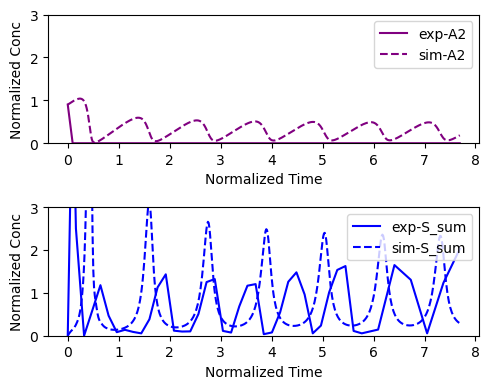

In [101]:
params = np.array([33, 30, 0.5, 20])/2
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])*2
init_cond = np.array([0.9, 0])
delayed_model_101 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
delayed_model_101.add_exp_data(df_MH_NatChem_fig3b_101)
fig101, axes101 = delayed_model_101.plot(exp=True, ylim=3)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


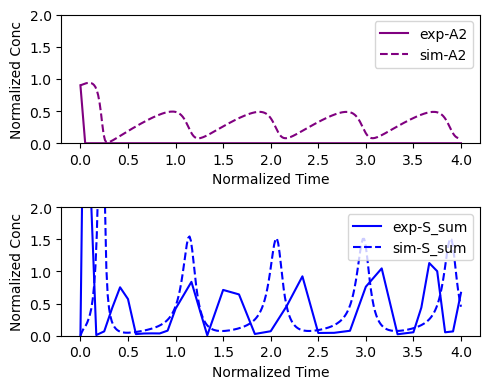

In [102]:
params = np.array([33, 30, 0.5, 20])
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])
init_cond = np.array([0.9, 0])
delayed_model_50 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
delayed_model_50.add_exp_data(df_MH_NatChem_fig3b_50)
fig50, axes50 = delayed_model_50.plot(exp=True, ylim=2)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]
Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


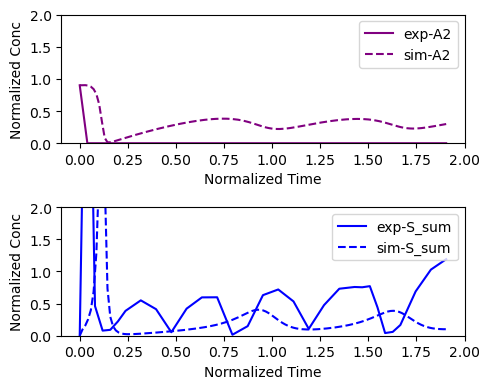

In [103]:
params = np.array([33, 30, 0.5, 20])/0.5
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])*0.5
init_cond = np.array([0.9, 0])
delayed_model_25 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
delayed_model_25.add_exp_data(df_MH_NatChem_fig3b_25)
fig25, axes25 = delayed_model_25.plot(exp=True, ylim=2)

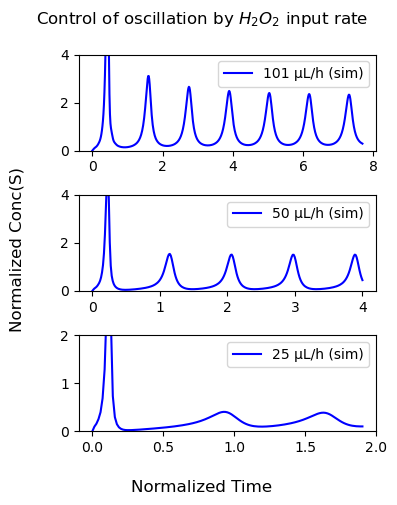

In [108]:
fig, ax = plt.subplots(3, 1, figsize=(4, 5))
axlist = [axes101, axes50, axes25]
legend = ['101 μL/h', '50 μL/h', '25 μL/h']
for r in range(3):
    ax[r].plot(axlist[r][1].lines[1].get_xdata(), axlist[r][1].lines[1].get_ydata(), color='b', label=legend[r]+' (sim)')
    ax[r].legend()
fig.suptitle('Control of oscillation by $H_2O_2$ input rate')
fig.supylabel('Normalized Conc(S)')
fig.supxlabel('Normalized Time')
ax[0].set_ylim(0, 4)
ax[1].set_ylim(0, 4)
ax[2].set_ylim(0, 2)
plt.tight_layout()

# Gradient

In [8]:
sol50, t = delayed_model_50.simulate(t=3)

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)


[  0  15  34  79 103 143 167 207]


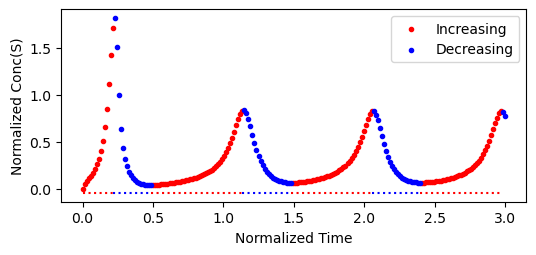

In [9]:
dcSdt = np.gradient(sol50[:, 1], t)
sign_changes = np.where(np.diff(np.sign(dcSdt)))[0]
sign_changes = np.insert(sign_changes, 0, 0)
print(sign_changes)
pos_sections = dcSdt >= 0
neg_sections = dcSdt < 0
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(t[pos_sections], sol50[:, 1][pos_sections], color ='r', marker='.', label='Increasing')
ax.scatter(t[neg_sections], sol50[:, 1][neg_sections], color ='b', marker='.', label='Decreasing')
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Normalized Conc(S)')
ax.legend()
for i in range(len(sign_changes) - 1):
    if i % 2 == 0:
        ax.hlines(-0.04, t[sign_changes[i]], t[sign_changes[i+1]], color='r', linestyles=':')
    else:
        ax.hlines(-0.04, t[sign_changes[i]], t[sign_changes[i+1]], color='b', linestyles=':')

In [10]:
def calc_rates(time, sol, delays, history, params, consts, details=False):
    alpha, beta, theta, phi = params
    lam, m = consts
    cA2 = sol[:, 0]
    cS = sol[:, 1]
    td1, td2 = delays
    cA2_past, cS_past = history
    def cA2_delayed(t, td):
        return cA2_past if t <= 0 else np.interp(t - td, time, cA2)
    def cS_delayed(t, td):
        return cS_past if t <= 0 else np.interp(t - td, time, cS)
    
    cS_td1 = np.array([cS_delayed(t, td1) for t in time])
    cS_td2 = np.array([cS_delayed(t, td2) for t in time])

    dcA2dt = 1 - alpha * cA2 * cS_td2**m - theta * cA2
    dcSdt = alpha/lam * cA2 * cS_td2**m - beta * cS_td1**m + theta/lam * cA2 - phi * cS
    rf_ac = alpha/lam * cA2 * cS_td2**m
    rf = theta/lam * cA2
    rde_ac = beta * cS_td1**m
    rde = phi * cS
    if details:
        return time, rf_ac, rf, rde_ac, rde
    else:
        return time, dcA2dt, dcSdt

In [11]:
params = np.array([33, 30, 0.5, 20])
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])
init_cond = np.array([0.9, 0])
t, dcA2dt, dcSdt = calc_rates(t, sol50, delay, init_cond, params, consts)

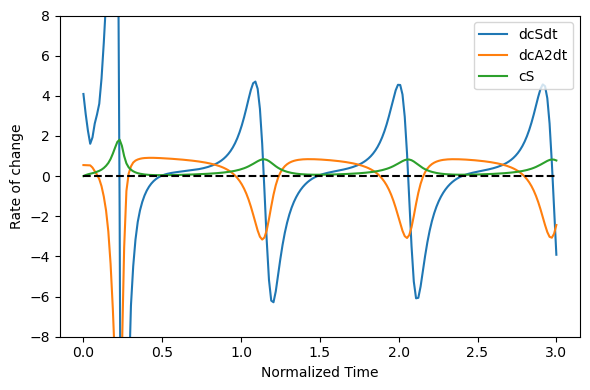

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t, dcSdt, label='dcSdt')
ax.plot(t, dcA2dt, label='dcA2dt')
ax.plot(t, sol50[:, 1], label='cS')
ax.hlines(0, 0, 3, linestyle='--', color='black')
ax.legend(loc=1)
ax.set_ylim(-8, 8)
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Rate of change')
plt.tight_layout()

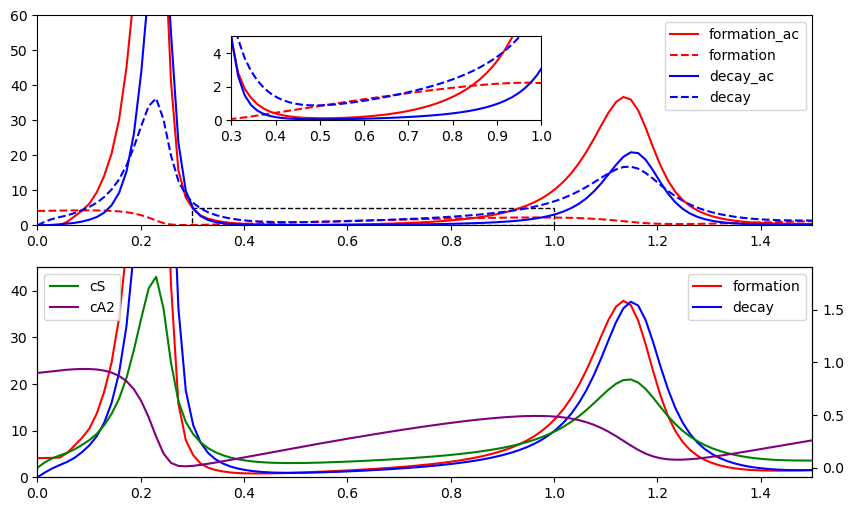

In [13]:
t, rf_ac, rf, rde_ac, rde = calc_rates(t, sol50, delay, init_cond, params, consts, details=True)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(t, rf_ac, label='formation_ac', color='r')
ax[0].plot(t, rf, label='formation', color='r', linestyle='--')
ax[0].plot(t, rde_ac, label='decay_ac', color='b')
ax[0].plot(t, rde, label='decay', color='b', linestyle='--')
ax[0].legend(loc=1)
ax[0].set_ylim(0, 60)
ax[1].plot(t, rf_ac + rf, label='formation', color='r')
ax[1].plot(t, rde_ac + rde, label='decay', color='b')
ax2 = ax[1].twinx()
ax2.plot(t, sol50[:, 1], label='cS', color='g')
ax2.plot(t, sol50[:, 0], label='cA2', color='purple')
ax2.legend(loc=2)
ax[1].legend(loc=1)
ax[1].set_ylim(0, 45)
[ax.set_xlim(0, 1.5) for ax in ax]

ax_inset = ax[0].inset_axes([0.25, 0.5, 0.4, 0.4])
for line in ax[0].lines:
    ax_inset.plot(line.get_xdata(), line.get_ydata(), color=line.get_color(), linestyle=line.get_linestyle())

ax_inset.set_xlim(0.3, 1.0)
ax_inset.set_ylim(0, 5)

rect = patches.Rectangle((0.3, 0), 0.7, 5, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')
ax[0].add_patch(rect)


# DMAP conc

In [58]:
params = np.array([33, 45, 0.5, 30])
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])
init_cond = np.array([0.9, 0])
delayed_model_50 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
delayed_model_50.add_exp_data(df_MH_NatChem_fig3b_50)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]


In [59]:
k1 = 5
k2 = 2
delayed_model_50.set_params([13 * k1, 32 * k2, 0.2 * k1, 21 * k2])
sol_dmap1, t_dmap1 = delayed_model_50.simulate(t=4)

Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


/Users/zhihengzhang/Documents/01_Research/03_Lab-SPF/Chemical_Oscillation_Model/osc_toolkit.py:223: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


In [60]:
k1 = 3
k2 = 1.8
delayed_model_50.set_params([13 * k1, 32 * k2, 0.2 * k1, 21 * k2])
sol_dmap2, t_dmap2 = delayed_model_50.simulate(t=4)

/Users/zhihengzhang/anaconda3/lib/python3.11/site-packages/jitcdde/_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)


In [61]:
k1 = 1.5
k2 = 1.2
delayed_model_50.set_params([13 * k1, 32 * k2, 0.2 * k1, 21 * k2])
sol_dmap3, t_dmap3 = delayed_model_50.simulate(t=4)

In [76]:
delayed_model_50.set_params([13, 32, 0.2, 21])
sol_dmap4, t_dmap4 = delayed_model_50.simulate(t=4)

/Users/zhihengzhang/anaconda3/lib/python3.11/site-packages/jitcdde/_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)
/Users/zhihengzhang/Documents/01_Research/03_Lab-SPF/Chemical_Oscillation_Model/osc_toolkit.py:223: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


/var/folders/8j/x1ffcm515s74s8v0g59y641r0000gn/T/ipykernel_28344/729205389.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


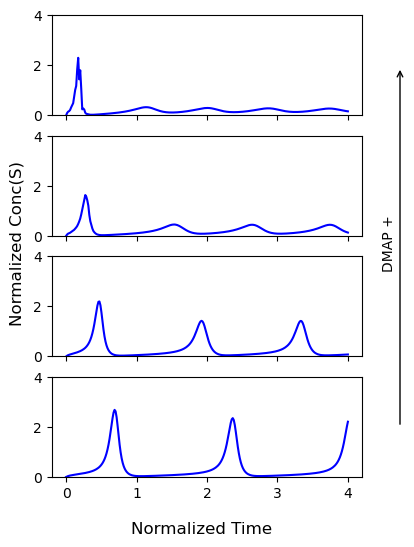

In [99]:
fig, ax = plt.subplots(4, 1, figsize=(4, 6))
m = 2
ax[0].plot(t_dmap1, sol_dmap1[:, 1] + sol_dmap1[:, 1]**m, color='b')
ax[1].plot(t_dmap2, sol_dmap2[:, 1] + sol_dmap2[:, 1]**m, color='b')
ax[2].plot(t_dmap3, sol_dmap3[:, 1] + sol_dmap3[:, 1]**m, color='b')
ax[3].plot(t_dmap4, sol_dmap4[:, 1] + sol_dmap4[:, 1]**m, color='b')
for a in ax[0: 3]:
    a.set_xticklabels([])
for a in ax:
    a.set_ylim(0, 4)
fig.supylabel('Normalized Conc(S)')
fig.supxlabel('Normalized Time')
ax[2].annotate('', xy=(1, 0.8), xytext=(1, 0.2), xycoords='figure fraction', textcoords='figure fraction', arrowprops=dict(arrowstyle='->'))
fig.text(0.95, 0.5, 'DMAP +', va='center', rotation='vertical')
plt.tight_layout()

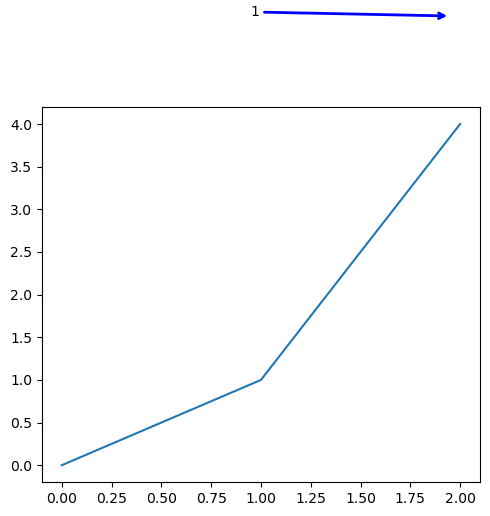

In [95]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot some dummy data
ax.plot([0, 1, 2], [0, 1, 4])

# Draw an arrow outside the plot
ax.annotate("1", xy=(0.9, 1), xytext=(0.5, 1),
             xycoords="figure fraction", textcoords="figure fraction",
             arrowprops=dict(arrowstyle="->", lw=2, color="blue"))

fig.tight_layout()

# Stirring Speed

Generating, compiling, and loading C code.
Using default integration parameters.


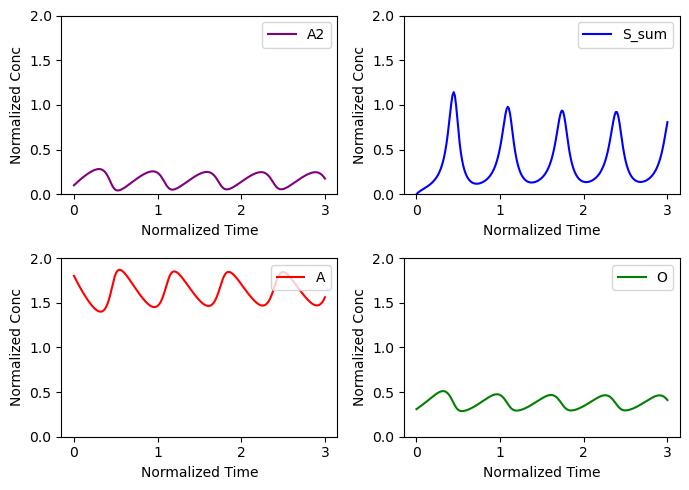

In [16]:
params = np.array([70, 25, 1.15, 23.8])
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])
init_cond = np.array([0.1, 0])
delayed_model_stirr = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
fig, axes = delayed_model_stirr.plot(ylim=2, t=3)
sol1, t1 = delayed_model_stirr.simulate(t=2)

Generating, compiling, and loading C code.
Using default integration parameters.


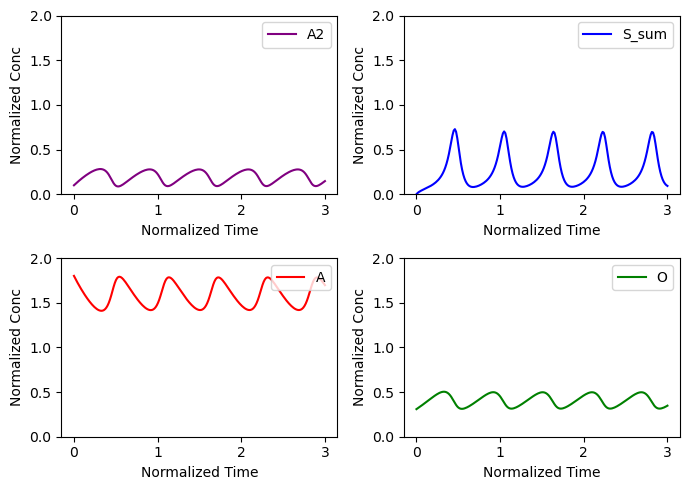

In [17]:
#Faster stirring
k1 = 1.1
k2 = 1.4
n = 2
params = np.array([70 * k1, 25 * k2, 1.15 * k1, 23.8 * k2])
delay = np.array([0.01, 0.04]) / n
delayed_model_stirr.set_params(params)
delayed_model_stirr.set_delay(delay)
fig, axes = delayed_model_stirr.plot(ylim=2, t=3)
sol2, t2 = delayed_model_stirr.simulate(t=2)

Generating, compiling, and loading C code.
Using default integration parameters.


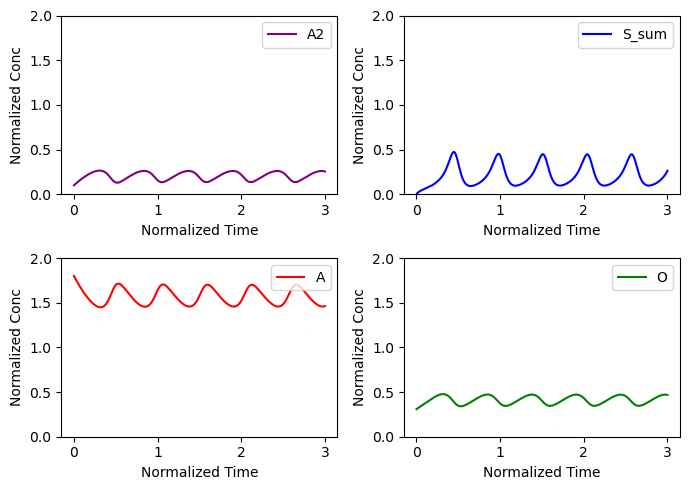

In [18]:
#More faster stirring
k1 = 1.3
k2 = 1.7
n = 3
params = np.array([70 * k1, 25 * k2, 1.15 * k1, 23.8 * k2])
delay = np.array([0.01, 0.04]) / n
delayed_model_stirr.set_params(params)
delayed_model_stirr.set_delay(delay)
fig, axes = delayed_model_stirr.plot(ylim=2, t=3)
sol3, t3 = delayed_model_stirr.simulate(t=2)

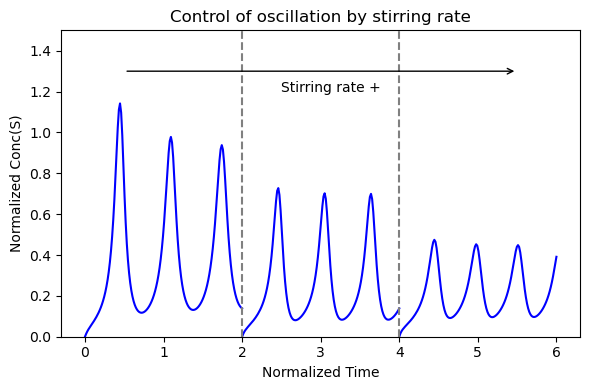

In [19]:
m = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t1, sol1[:, 1] + sol1[:, 1]**m, color='b')
ax.plot(t2+2, sol2[:, 1] + sol2[:, 1]**m, color='b')
ax.plot(t3+4, sol3[:, 1] + sol3[:, 1]**m, color='b')
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Normalized Conc(S)')
ax.set_ylim(0, 1.5)
ax.axvline(2, linestyle='--', color='grey')
ax.axvline(4, linestyle='--', color='grey')
ax.set_title('Control of oscillation by stirring rate')
ax.annotate("", xytext=(0.5, 1.3), xy=(5.5, 1.3),arrowprops=dict(arrowstyle="->"))
ax.text(2.5, 1.2, "Stirring rate +")
plt.tight_layout()